<center>

# **如何进行GLM 一阶分析**

</center>

***

本教程以 NARPS 数据为例，基于 [Nilearn 工具包](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/index.html)，详细介绍一阶分析的基本流程。

本节介绍参数调制（Parametric Modulation）的分析策略，首先会介绍什么是Parametric Modulation，其次会以narps数据为例进行具体代码展示。

对于基于 GIfTI（.gii）格式的表层空间分析内容，本教程不作详细展开，感兴趣的读者可参考以下补充代码文件：

1. Step_4_Analysis/GLM/step4_surface_based_firstlevel.py
2. Step_4_Analysis/GLM/step4_surface_based_firstlevel_modulation.py

- **什么是Parametric Modulation**
- **Step 1: events文件的读取与预处理**
- **Step 2: 基于confounds文件的运动校正**
- **Step 3: 使用 FirstLevelModel 进行建模与估计**
- **Step 4: 设置条件对比（contrast）并导出结果**

# 什么是Parametric Modulation

在默认情况下，fMRI 的 GLM 模型会假设同一条件下的所有事件（event）都具有相同幅度的 BOLD 反应。然而，有时我们会对某些事件的 BOLD 反应强度有特定的预期，这种预期可以通过参数调制（Parametric Modulation）纳入模型。参数调制的原理是：为每一个事件指定一个预测的幅度值。这样做既可以改进模型的拟合效果，也可以用来检验假设，例如 BOLD 反应是否会随着某些事件特征（如试次强度或反应时间）而变化。

假设你有一个任务，其中呈现一束光，每次光的亮度不同。如果你记录了每次光亮度的数值，你就可以检查：BOLD 信号是否随着亮度增加而增强？

这个“信号是否随着某种变量变化而变化”的过程，就是Parametric Modulation。

**参考资料：**

> https://andysbrainbook.readthedocs.io/en/latest/PM/PM_Overview.html

> Sabrina M. Tom et al. ,The Neural Basis of Loss Aversion in Decision-Making Under Risk.Science315,515-518(2007).DOI:10.1126/science.1134239


In [20]:
# 导入所需的库
import os
import pandas as pd
import numpy as np
import os.path as op
import nibabel as nb
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_stat_map
from nilearn.glm.first_level import make_first_level_design_matrix
# 用于计算不同条件之间的对比
from itertools import combinations 
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

In [21]:
# 定义函数，根据头动参数（帧位移与六个方向的运动参数）识别头动过大的时间点并删除
def motion_controlled_event_timetable(event_table, fd_data, six_absolute_motion, TR, FD_thr, ab_motion_thr):
    # 检测超出帧位移（FD）阈值的时间点
    out_motion_detect = fd_data.to_numpy()[:] > FD_thr
    out_motion_index = np.where(out_motion_detect == True)
    
    # 检测超过绝对运动阈值的时间点
    six_motion_ex = np.where(np.sum((six_absolute_motion > ab_motion_thr) == True, 1) > 0)
    
    # 将运动时间点通过乘以 TR 转换为实际时间
    out_motion_time = np.array([])
    if len(out_motion_index[0]) > 0:
        out_motion_time = (out_motion_index[0][:] + 1) * TR
    if len(six_motion_ex[0]) > 0:
        six_motion_time = (six_motion_ex[0] + 1) * TR
        out_motion_time = np.concatenate((out_motion_time, six_motion_time), axis=0)
        out_motion_time = np.unique(out_motion_time)
    
    # 为事件表添加一个新列'time_end'，计算每个事件的结束时间
    # 使用lambda函数计算：结束时间 = 开始时间(onset) + 持续时间(duration)
    tmp_timetable = event_table.assign(time_end=lambda dataframe: dataframe['onset'] + dataframe['duration'])
    tmp_timetable = tmp_timetable.reset_index(drop=True)
    
    # 标记运动超过阈值的时间点
    block_time_judge = np.zeros(tmp_timetable.shape[0])
    block_time_in = np.zeros(tmp_timetable.shape[0])
    try:
        for n_time in range(tmp_timetable.shape[0]):
            for i in out_motion_time:
                time_judge_0 = (i <= tmp_timetable.loc[n_time, 'time_end'])
                block_time_judge[n_time] += time_judge_0
                time_judge_1 = (i <= tmp_timetable.loc[n_time, 'time_end']) * (i >= tmp_timetable.loc[n_time, 'onset'])
                block_time_in[n_time] += time_judge_1
            
        tmp_timetable = tmp_timetable.assign(
            time_delete=block_time_judge * TR,
            delete_time_inblock=block_time_in
        )
        tmp_timetable.loc[:, 'duration'] = tmp_timetable['duration'] - tmp_timetable['delete_time_inblock'] * TR
        
        # 调整起始时间 (onset) 并重新计算结束时间
        for n_time in range(tmp_timetable.shape[0]):
            if n_time != 0:
                tmp_timetable.loc[n_time, 'onset'] = tmp_timetable.loc[n_time, 'onset'] - tmp_timetable.loc[n_time, 'time_delete']
            tmp_timetable.loc[n_time, 'time_end'] = tmp_timetable.loc[n_time, 'onset'] + tmp_timetable.loc[n_time, 'duration']
    except Exception as e:
        print("Error in motion_controlled_event_timetable:", e)
        out_motion_time = False
        tmp_timetable = event_table
    return [tmp_timetable, out_motion_time]

In [ ]:
# 定义函数，删除对应运动时间点的 NIfTI 时间点
def correct_motion_for_niidata(motion_corrected_path, subname, run, task_file, nii_data, TR, out_motion_time):
    motion_corrected_subfolder = op.join(motion_corrected_path, subname)
    if not os.path.exists(motion_corrected_subfolder):
        os.makedirs(motion_corrected_subfolder)
    motion_corrected_nii = op.join(motion_corrected_subfolder, subname + task_file)
    niidata = nb.load(nii_data)
    timepoints_to_delete = ((out_motion_time / TR).astype('int64')) - 1
    motion_corrected_data = np.delete(niidata.get_fdata(), timepoints_to_delete, axis=3)
    motion_corrected_nii_data = nb.Nifti1Image(motion_corrected_data, header=niidata.header, affine=niidata.affine)
    motion_corrected_nii_data.header.set_data_dtype(np.int16)
    nb.save(motion_corrected_nii_data, motion_corrected_nii)
    return motion_corrected_nii

In [22]:
# 设置数据根目录
rootdir = '/Volumes/ss/ds001734'
# 可以根据需要修改被试列表(sublist)和run列表(runs)
# 这里只使用Narps数据中的第一个被试，一共是4次run
sublist = ['001']  
runs = ['01', '02', '03', '04']
# task名称，可以根据实际数据修改
taskname = 'MGT'
# 根据你的数据修改TR时间
# 对于公开数据集，TR值通常可以在以下位置找到：
# 1. 原始论文的Methods部分
# 2. BIDS格式数据的task-*_bold.json文件中的"RepetitionTime"字段
TR = 1.0  
# 设置帧位移和绝对运动阈值，这是绝大多数研究中常用的阈值，你也可以根据实际情况进行调整
FD_thr = 0.2  
ab_motion_thr = 3  

# 设置输出路径
out_path = op.join(rootdir, 'derivatives', 'first_level_model_corrected_nii')
motion_corrected_path = op.join(rootdir, 'derivatives', 'motion_corrected_data_nii')

# 设置是否进行头动校正（删除头动过大的时间点）
# 设置为 False 可避免删除由于头动造成的运动伪影较大的时间帧
do_motion_exclusion = False  


在实际的 GLM 分析中，我们通常不会只处理一个被试，因此使用循环结构可以大幅提高分析效率。

不过，如果你希望深入理解循环代码中每一行的含义，以及各个变量的具体内容，可以在每行代码下方添加 `print()` 语句，或者单独创建一个代码块，打印变量的输出结果来进行查看。


In [ ]:
# 以`subeventdir` 为例
# 取消下面代码的注释，运行即可查看`subeventdir`变量的输出结果是什么
# subeventdir

# 或者使用print语句查看，取消注释运行查看输出结果即可
# print(f"events文件的路径：{subeventdir}")

关于nilearn中 'FirstLevelModel' 各参数的介绍，可以参考：

> https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


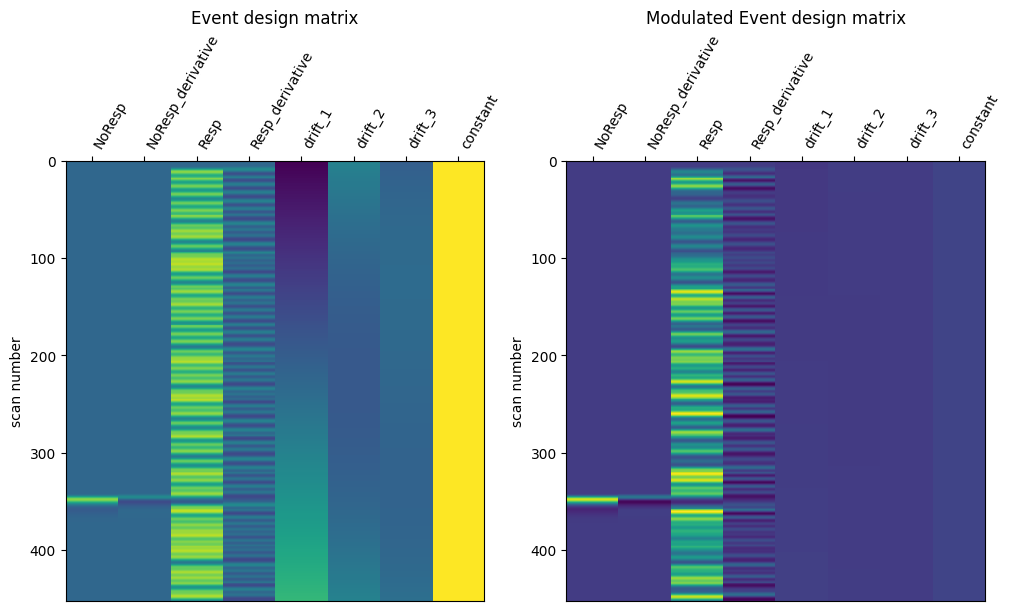

[FirstLevelModel.fit] A 'modulation' column was found in the given events data and is used.
Contrast Resp for sub-001, run 01 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_nii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_Resp_zmap.nii.gz
Contrast NoResp for sub-001, run 01 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_nii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_NoResp_zmap.nii.gz
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


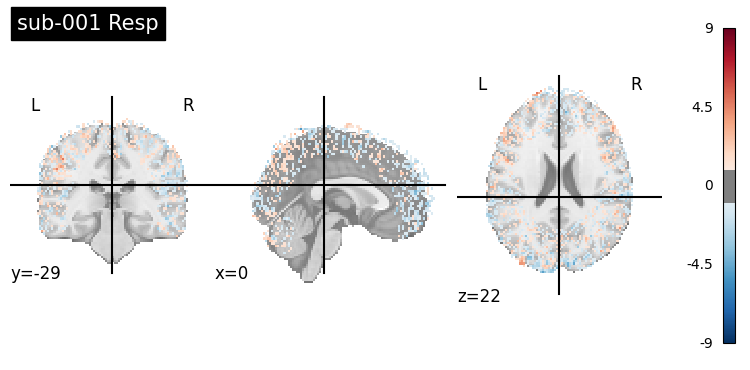

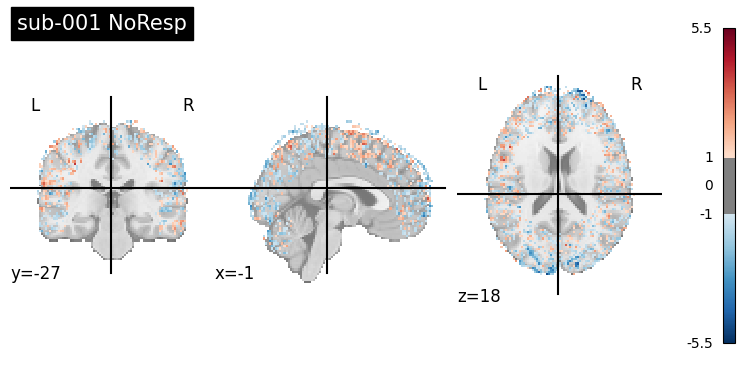

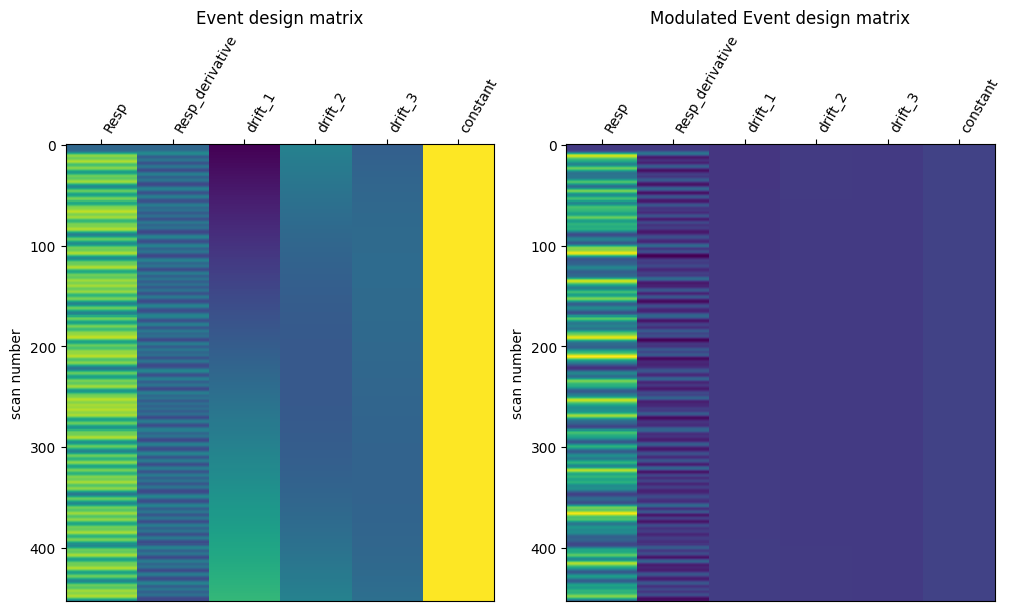

[FirstLevelModel.fit] A 'modulation' column was found in the given events data and is used.
Contrast Resp for sub-001, run 02 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_nii/sub-001/stats_results/run-02/sub-001_task-MGT_run-02_Resp_zmap.nii.gz
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


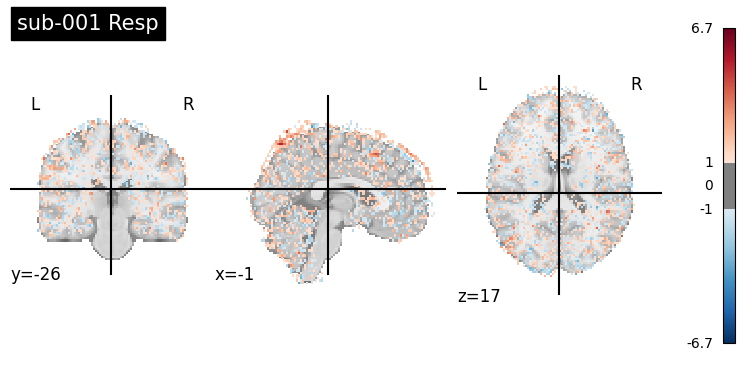

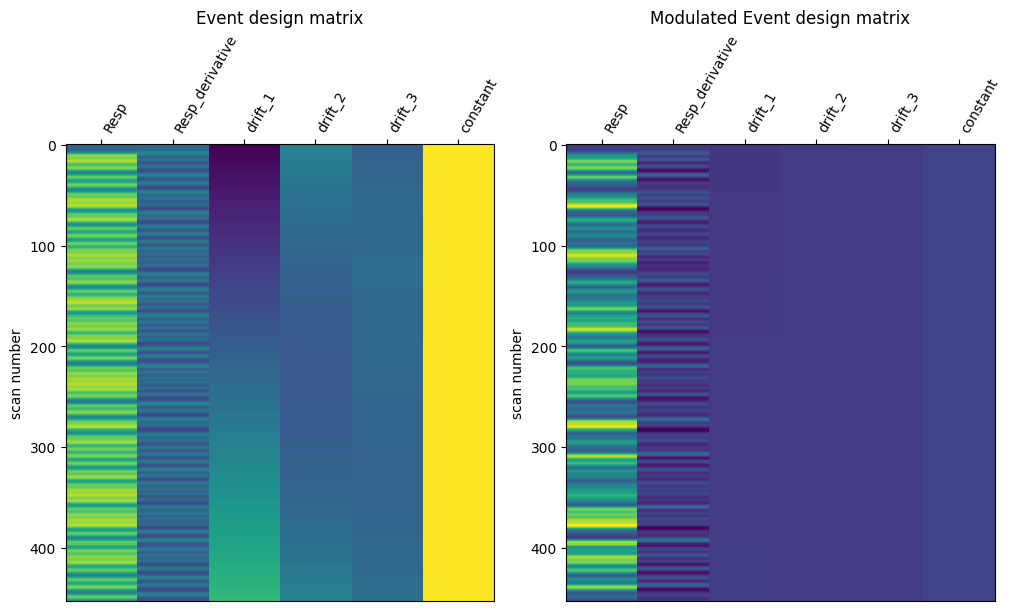

[FirstLevelModel.fit] A 'modulation' column was found in the given events data and is used.
Contrast Resp for sub-001, run 03 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_nii/sub-001/stats_results/run-03/sub-001_task-MGT_run-03_Resp_zmap.nii.gz
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


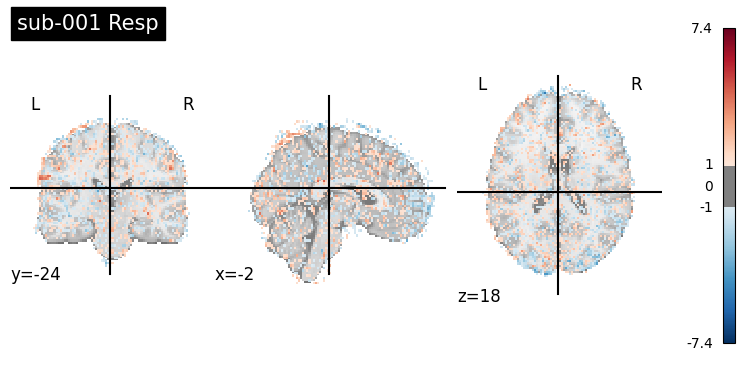

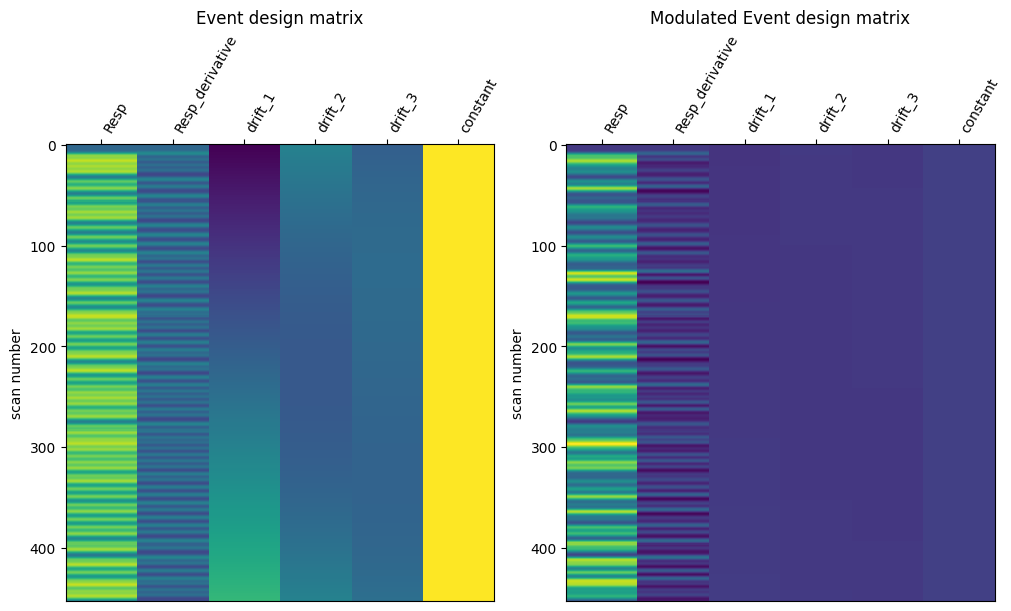

[FirstLevelModel.fit] A 'modulation' column was found in the given events data and is used.
Contrast Resp for sub-001, run 04 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_nii/sub-001/stats_results/run-04/sub-001_task-MGT_run-04_Resp_zmap.nii.gz


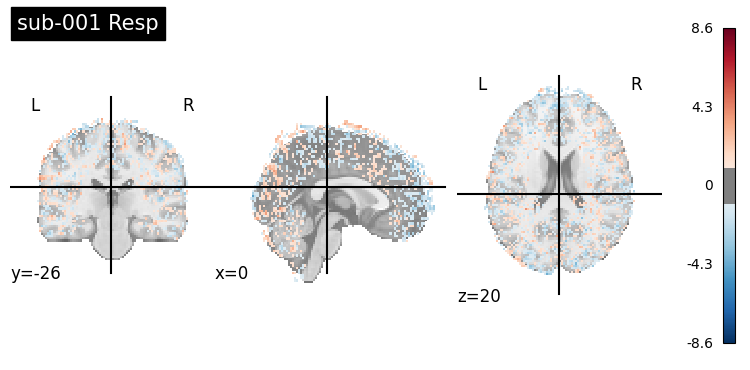

In [23]:
# 主要代码：GLM一阶分析的核心循环
# 遍历每个被试和每个run，进行独立的一阶分析
for sub in sublist:
    # 构建被试名称
    subname = 'sub-' + sub
    # subeventdir 是存放events文件的路径
    subeventdir = op.join(rootdir, subname, 'func')
    # subimagedir 是存放fmriprep预处理后图像结果的路径
    subimagedir = op.join(rootdir, 'derivatives', 'fmriprep', subname, 'func')
    for run in runs:
        # 构建3个必需文件的完整路径
        # events文件：需包含实验设计的信息，在nilearn中'onset'和'duration'是必需的
        sub_event_file = op.join(subeventdir, f'{subname}_task-{taskname}_run-{run}_events.tsv')
        # NIfTI数据文件：预处理后的fmri图像数据，已配准到标准空间
        sub_niidata_file = op.join(subimagedir, f'{subname}_task-{taskname}_run-{run}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
        # confounds文件：包含头动参数等需要回归的变量
        sub_motioninfo_file = op.join(subimagedir, f'{subname}_task-{taskname}_run-{run}_bold_confounds.tsv')

        # 检查是否存在所有必要的文件
        if not (os.path.exists(sub_event_file) and os.path.exists(sub_niidata_file) and os.path.exists(sub_motioninfo_file)):
            print(f"Missing files for {subname}, run {run}")
            continue

        # 加载events文件数据
        event_data = pd.read_csv(sub_event_file, sep='\t')
        # 将'participant_response' 重命名为'trial_type'
        # 将event文件中被试反应的数据重新编码为两种trial_type
        # 如果被试没有反应（'NoResp'），则标记为 'NoResp'；如果被试有反应（任何非'NoResp'的值），则标记为 'Resp'
        event_data['trial_type'] = event_data['participant_response'].apply(
            lambda x: 'NoResp' if x == 'NoResp' else 'Resp'
        )

        # 确保'gain'列作为 modulation effect 
        if 'gain' not in event_data.columns:
            print(f"'gain' column not found in {sub_event_file}")
            continue
        else:
            event_data.rename(columns={'gain': 'modulation'}, inplace=True)
  
        # 读取头动参数文件，包含帧位移和六个方向的头动参数
        confounds = pd.read_csv(sub_motioninfo_file, sep='\t')
        # 处理缺失值
        confounds = confounds.fillna(0)

        # 获取帧位移（FD）数据
        if 'FramewiseDisplacement' in confounds.columns:
            fd = confounds[['FramewiseDisplacement']]
        elif 'framewise_displacement' in confounds.columns:
            fd = confounds[['framewise_displacement']]
        else:
            print(f"FD column not found in {sub_motioninfo_file}")
            continue

        # 获取六个方向的头动参数数据
        motion_params = confounds[['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]

        # 头动校正
        # 如果设置了 do_motion_exclusion 为 True，则进行头动校正
        # 这将删除头动过大的时间点，并返回校正后的事件数据
        if do_motion_exclusion:
            [event_data_corrected, out_motion_time] = motion_controlled_event_timetable(event_data, fd, motion_params, TR, FD_thr, ab_motion_thr)
            # 保存校正后的 events 数据
            out_sub_path = op.join(out_path, subname)
            if not os.path.exists(out_sub_path):
                os.makedirs(out_sub_path)
            event_out_file = op.join(out_sub_path, f'{subname}_task-{taskname}_run-{run}_events_corrected.tsv')
            event_data_corrected.to_csv(event_out_file, sep='\t', index=False)
            # 校正 NIfTI 数据
            if not isinstance(out_motion_time, bool):
                task_file = f'_task-{taskname}_run-{run}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
                corrected_nii_file = correct_motion_for_niidata(motion_corrected_path, subname, run, task_file, sub_niidata_file, TR, out_motion_time)
                fmri_img = nb.load(corrected_nii_file)
                # 校正头动参数
                timepoints_to_delete = ((out_motion_time / TR).astype('int64')) - 1
                motion_params_corrected = motion_params.drop(motion_params.index[timepoints_to_delete]).reset_index(drop=True)
            else:
                fmri_img = nb.load(sub_niidata_file)
                motion_params_corrected = motion_params
                event_data_corrected = event_data
        else:
            event_data_corrected = event_data
            fmri_img = nb.load(sub_niidata_file)
            motion_params_corrected = motion_params

        # 计算每个时间点的帧时间
        # fmri_img.shape[3])应等于 = 453
        frame_times = (
            np.arange(fmri_img.shape[3]) * TR
        )  

        # 这是没有modulation的设计矩阵，只检测条件是否激活大脑，不考虑强度变化
        unmodulated_matrix = event_data_corrected[['onset', 'duration', 'trial_type']]
        # 这考虑了大脑活动是否会随modulation参数而变化，需要将'modulation'列添加到设计矩阵中
        modulated_matrix = event_data_corrected[['onset', 'duration', 'trial_type','modulation']]
        
        GLM_matrix_unmodulated = make_first_level_design_matrix(
            frame_times,
            unmodulated_matrix,
            drift_model="polynomial",
            drift_order=3,
            hrf_model="spm + derivative",
        )
        
        GLM_matrix_modulated = make_first_level_design_matrix(
            frame_times,
            modulated_matrix,
            drift_model="polynomial",
            drift_order=3,
            hrf_model="spm + derivative",
        )
        # 比较两种设计矩阵（GLM_matrix_unmodulated 和 GLM_matrix_modulated）
        # 绘制设计矩阵
        fig, (ax1, ax2) = plt.subplots(
            figsize=(10, 6), nrows=1, ncols=2, constrained_layout=True
        )

        plot_design_matrix(GLM_matrix_unmodulated, axes=ax1,rescale=False)
        ax1.set_title("Event design matrix", fontsize=12)
        plot_design_matrix(GLM_matrix_modulated, axes=ax2,rescale=False)
        ax2.set_title("Modulated Event design matrix", fontsize=12)
        plt.show()

        # 执行一阶GLM分析
        fmri_glm = FirstLevelModel(
            t_r=TR,
            noise_model='ar1',
            hrf_model='spm + derivative',
            # 指定设计矩阵中使用的漂移模型类型
            drift_model='polynomial',
            # 你可以根据需要调整漂移模型的阶数
            # drift_order=3, 表示使用三阶多项式漂移模型
            drift_order=3,
            # 可以根据需要调整高通滤波器的截止频率
            # 这里设置为1/128Hz，适用于大多数fMRI数据
            high_pass=1./128,  
            # 是否对信号进行缩放
            # 通常在进行GLM分析时不需要缩放信号
            signal_scaling=False,  
            minimize_memory=False
        )
        
        # 使用modulated_matrix进行拟合
        fmri_glm = fmri_glm.fit(
            fmri_img,
            events=modulated_matrix,
            confounds=motion_params_corrected
        )

        # 定义 contrasts
        # Narps的events数据的 'trial_type' 列包含条件名称
        conditions = event_data_corrected['trial_type'].unique()
        design_matrix = fmri_glm.design_matrices_[0]

        # 为每个条件创建对比向量
        contrasts = {}
        for cond in conditions:
            # 创建对应条件的对比向量
            cond_vector = np.array([1 if c == cond else 0 for c in design_matrix.columns])
            contrasts[cond] = cond_vector
        # 计算每个条件相对于基线（baseline）的对比
        out_sub_path = op.join(out_path, subname)
        stats_results_path = op.join(out_sub_path, 'stats_results', f'run-{run}')
        if not os.path.exists(stats_results_path):
            os.makedirs(stats_results_path)
        for contrast_id, contrast_val in contrasts.items():
            z_map = fmri_glm.compute_contrast(contrast_val, output_type='z_score')
            z_map_file = op.join(stats_results_path, f'{subname}_task-{taskname}_run-{run}_{contrast_id}_zmap.nii.gz')
            z_map.to_filename(z_map_file)
            print(f"Contrast {contrast_id} for {subname}, run {run} completed and saved to {z_map_file}")
            # Optionally, plot the contrast map
            # 可选：绘制无阈值对比图
            plot_stat_map(z_map, title=f'{subname} {contrast_id}', display_mode='ortho', threshold=1.0)


如果你已经运行了上述代码，当你看到矩阵 'GLM_matrix_unmodulated' 和 'GLM_matrix_modulated' 可视化后，对他们的形状和构成感到疑惑时，可以把两个矩阵的值 print 出来看看。

In [17]:
print(GLM_matrix_unmodulated)
print(GLM_matrix_modulated)

           Resp  Resp_derivative   drift_1   drift_2   drift_3  constant
0.0    0.000000         0.000000 -0.500000  0.166298 -0.049669       1.0
1.0    0.000000         0.000000 -0.497788  0.164090 -0.048350       1.0
2.0    0.000000         0.000000 -0.495575  0.161893 -0.047046       1.0
3.0    0.000000         0.000000 -0.493363  0.159705 -0.045757       1.0
4.0    0.000000         0.000000 -0.491150  0.157527 -0.044482       1.0
...         ...              ...       ...       ...       ...       ...
448.0  0.803678        -0.054417  0.491150  0.157527  0.044482       1.0
449.0  0.702958        -0.136132  0.493363  0.159705  0.045757       1.0
450.0  0.540651        -0.177684  0.495575  0.161893  0.047046       1.0
451.0  0.361757        -0.175147  0.497788  0.164090  0.048350       1.0
452.0  0.201697        -0.145705  0.500000  0.166298  0.049669       1.0

[453 rows x 6 columns]
            Resp  Resp_derivative   drift_1   drift_2   drift_3  constant
0.0     0.000000         0

当你 'print' 后看到两个矩阵中每一列具体的值的时候，你会发现它们是完全不同的，这是因为当我们在 'GLM_matrix_modulate' 中 'modulation' 列时，Nilearn 的 'make_first_level_design_matrix' 函数会：

1. 自动处理参数调制：对于每个 trial_type，如果存在 modulation 列，会创建modulation版本的回归子
   
2. 只为实际存在的条件创建列：如果某个条件在数据中不存在，就不会在设计矩阵中创建对应的列

参考资料：

> https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_design_matrix.html